In [1]:
%matplotlib nbagg

In [2]:
import os
import numpy
from matplotlib.pyplot import subplots

In [3]:
nframes = 512
shape = 512, 512
volume = (512, 512, 512)
center = (260, 250)
pixel_size = 55e-6
distance = 1
phi = numpy.linspace(-80, 80, nframes).astype(numpy.float32)

In [4]:
Y, X =  numpy.ogrid[:shape[0], :shape[1]]

In [5]:
#%%time 
Yd, Xd =  numpy.ogrid[:shape[0], :shape[1]]
x = pixel_size*(Xd - center[1])
y = pixel_size*(Yd - center[0])
d = numpy.sqrt(x*x + y*y + distance*distance)

x0 = x/d
y0 = y/d
z0 = distance/d - 1.0

cp = numpy.cos(numpy.deg2rad(phi[55]))
sp = numpy.sin(numpy.deg2rad(phi[55]))
R = numpy.array([[cp, 0, sp],[0, 1, 0], [-sp, 0, cp]])
#
XYZ = distance/pixel_size * R.dot(numpy.stack((x0, y0, z0),axis=0).reshape((3,-1))).reshape((3,)+shape)

In [6]:
XYZ[:, 100, 60], XYZ[:, 101, 60], XYZ[:, 100, 61], XYZ[:, 101, 61]

(array([ -85.39420715, -159.98507069, -169.71732977]),
 array([ -85.40204782, -158.98524069, -169.71339962]),
 array([ -84.94613899, -159.98516238, -168.82349515]),
 array([ -84.95397945, -158.98533181, -168.81956456]))

In [7]:
%load_ext pyopencl.ipython_ext


In [8]:
import pyopencl as cl
from pyopencl import array as cla

In [9]:
os.environ["PYOPENCL_CTX"]="0:0"
ctx = cl.create_some_context(interactive=False)
queue = cl.CommandQueue(ctx)
ctx

<pyopencl.Context at 0x3727c70 on <pyopencl.Device 'GeForce GT 1030' on 'NVIDIA CUDA' at 0x3710110>>

In [10]:
%%cl_kernel 
/* 2D kernel, one thread per input pixel
 * 
 * pixel start at 0 and finish at 1, the center is at 0.5
 * thread ids follow the memory location convention (zyx) not the math x,y,z convention 
 */ 

inline void atomic_add_global_float(volatile global float *addr, float val)
{
   union {
       uint  u32;
       float f32;
   } next, expected, current;
   current.f32    = *addr;
   do {
       expected.f32 = current.f32;
       next.f32     = expected.f32 + val;
       current.u32  = atomic_cmpxchg( (volatile global uint *)addr,
                                      expected.u32, next.u32);
   } while( current.u32 != expected.u32 );
}

float2 inline calc_position_real(float2 index,
                                 float2 center,
                                 float pixel_size)
{
    return (index - center) * pixel_size;
}


float3 inline calc_position_rec(float2 index,
                                float2 center,
                                float pixel_size,
                                float distance,
                                float3 Rx,
                                float3 Ry,
                                float3 Rz)
{
    float2 pos2 = calc_position_real(index, center, pixel_size);
    float d = sqrt(distance*distance + dot(pos2, pos2));
    float3 pos3 = (float3)(pos2.x/d, pos2.y/d, distance/d-1.0f);
    float scale = distance*distance/pixel_size;
    return scale * (float3)(dot(Rx, pos3), dot(Ry, pos3), dot(Rz, pos3));
}
                                
kernel void regid_CDI(global float* image,
                      const  int height,
                      const  int width,
                      const  float pixel_size,
                      const  float distance,
                      const  float phi,
                      const  float center_x,
                      const  float center_y,
                      global float *volume,
                      const  int volume_shape,
                      const  int oversampling)
{
    int tmp;
    size_t where_in, where_out;
    float value, cos_phi, sin_phi;
    float2 pos2, center = (float2)(center_x, center_y);
    float3 Rx, Ry, Rz, recip;
    //float4 corners_x, corners_y;
    
    if ((get_global_id(0)>=height) || (get_global_id(1)>=width))
        return;
    
    where_in = width*get_global_id(0)+get_global_id(1);
    
    cos_phi = cos(phi*M_PI_F/180.0f);
    sin_phi = sin(phi*M_PI_F/180.0f);
    Rx = (float3)(cos_phi, 0.0f, sin_phi);
    Ry = (float3)(0.0f, 1.0f, 0.0f);
    Rz = (float3)(-sin_phi, 0.0f, cos_phi);
    
    //this is the center of the pixel
    pos2 = (float2)(get_global_id(1)+0.5f, get_global_id(1) + 0.5f); 
    recip = calc_position_rec(pos2, center, pixel_size, distance, Rx, Ry, Rz);
    value = image[where_in];

    // No oversampling for now
    
    tmp = (int)recip.x + volume_shape/2;
    if ((tmp>=0) && (tmp<volume_shape))
    {
        where_out = tmp;
        tmp = (int)recip.y + volume_shape/2;
        if ((tmp>=0) && (tmp<volume_shape))
        {
            where_out += tmp*volume_shape;
            tmp = (int)recip.z + volume_shape/2;
            if ((tmp>=0) && (tmp<volume_shape))
            {
                where_out += tmp*volume_shape*volume_shape;  
                atomic_add_global_float(&volume[2*where_out], value);
                atomic_add_global_float(&volume[2*where_out+1], 1.0f);
            }
        }               
    }
}

In [11]:
image_d = cla.empty(queue, shape, dtype=numpy.float32)
volume_d = cla.empty(queue, volume+(2,), dtype=numpy.float32)

In [12]:
volume_d.fill(0.0)
image_d.fill(1.0)
pass

In [13]:
%%time
for i in phi:
    evt = regid_CDI(queue, shape, None,
                    image_d.data,
                    numpy.int32(shape[0]),numpy.int32(shape[1]),
                    numpy.float32(pixel_size),
                    numpy.float32(distance),
                    numpy.float32(i),
                    numpy.float32(center[1]),numpy.float32(center[0]),
                    volume_d.data,
                    numpy.int32(volume[0]),
                    numpy.int32(0))
evt.wait()

CPU times: user 5.41 s, sys: 2.06 s, total: 7.47 s
Wall time: 7.48 s


In [14]:
volume_h=volume_d.get()

<IPython.core.display.Javascript object>


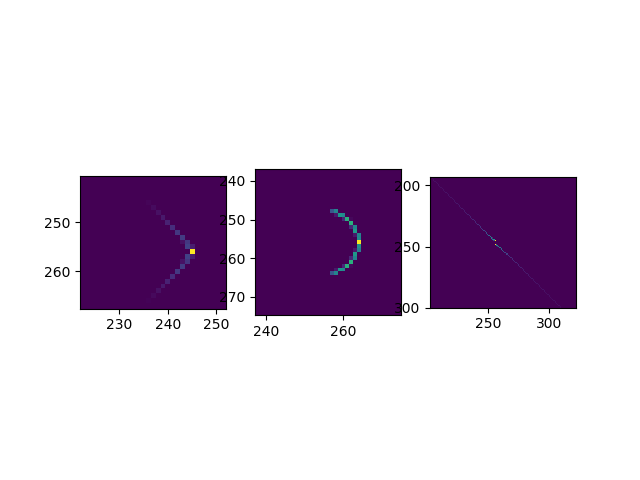

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [15]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
fig, ax = subplots(1, 3)
x=y=z=255
i0=ax[0].imshow(volume_h[:,:,x,0])
i1=ax[1].imshow(volume_h[:,y,:,0])
i2=ax[2].imshow(volume_h[z,:,:,0])
x = widgets.IntSlider(x, 0,volume[2]-1)
y = widgets.IntSlider(y, 0,volume[1]-1)
z = widgets.IntSlider(z, 0,volume[0]-1)
ui = widgets.HBox([x, y, z])
def update(x, y, z):
    i0.set_data(volume_h[:,:,x,0])
    i1.set_data(volume_h[:,y,:,0])
    i2.set_data(volume_h[z,:,:,0])
    fig.canvas.draw()
    fig.canvas.flush_events()

out = widgets.interactive_output(update, {'x': x, 'y': y, 'z': z})

display(ui, out)

In [16]:
volume_h[0,:,:,0].mean()

0.017578125

In [17]:
512*512

262144

<IPython.core.display.Javascript object>


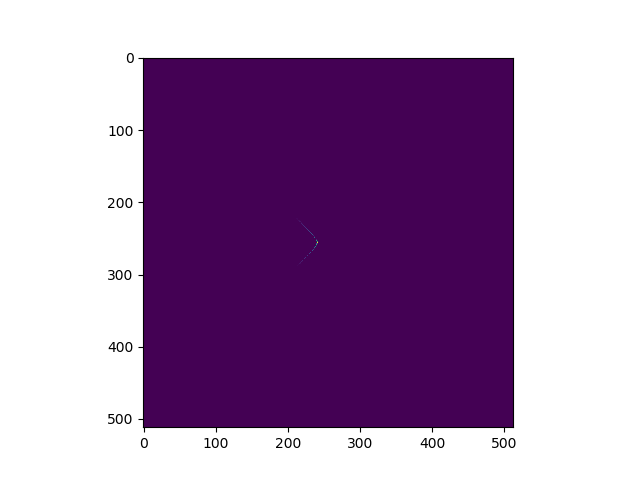

In [18]:
fig,ax = subplots()
img = ax.imshow(volume_h[:,:,250,0])

In [19]:
img.set_data(volume_h[:,:,251,0])

In [20]:
phi

array([-80.        , -79.68689   , -79.37378   , -79.06067   ,
       -78.74755   , -78.43444   , -78.12133   , -77.80822   ,
       -77.49511   , -77.182     , -76.86888   , -76.55577   ,
       -76.24266   , -75.92955   , -75.61644   , -75.30333   ,
       -74.99021   , -74.6771    , -74.36399   , -74.05088   ,
       -73.73777   , -73.42466   , -73.11155   , -72.79843   ,
       -72.48532   , -72.17221   , -71.8591    , -71.54599   ,
       -71.23288   , -70.91976   , -70.60665   , -70.29354   ,
       -69.98043   , -69.66732   , -69.35421   , -69.0411    ,
       -68.72798   , -68.41487   , -68.10176   , -67.78865   ,
       -67.47554   , -67.16243   , -66.84931   , -66.5362    ,
       -66.22309   , -65.90998   , -65.59687   , -65.28376   ,
       -64.97064   , -64.65753   , -64.34442   , -64.03131   ,
       -63.7182    , -63.405087  , -63.091976  , -62.778866  ,
       -62.46575   , -62.15264   , -61.83953   , -61.52642   ,
       -61.213306  , -60.900196  , -60.587086  , -60.27

In [21]:
volume_h[...,0].sum(), volume_h[...,1].sum()

(133265410.0, 133265410.0)

In [22]:
512*512*512

134217728